In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,BatchNormalization,Activation,Add,Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()

/home/peter/anaconda3/envs/dnn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
version = 5
basic_name = f'Unet_resnet_v{version}-1080'
save_model_name = basic_name + '.model'
submission_file = basic_name + '.csv'

print(save_model_name)
print(submission_file)

Unet_resnet_v5-1080.model
Unet_resnet_v5-1080.csv


In [3]:
img_size_ori = 101
img_size_target = 101


In [4]:
# Loading of training/testing ids and depths
train_df = pd.read_csv("../input/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("../input/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [5]:
train_df["images"] = [np.array(load_img("../input/train/images/{}.png".format(idx), grayscale=True)) for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

In [6]:
train_df["masks"] = [np.array(load_img("../input/train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

HBox(children=(IntProgress(value=0, max=4000), HTML(value='')))

In [7]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)


Text(0.5,0,'Coverage class')

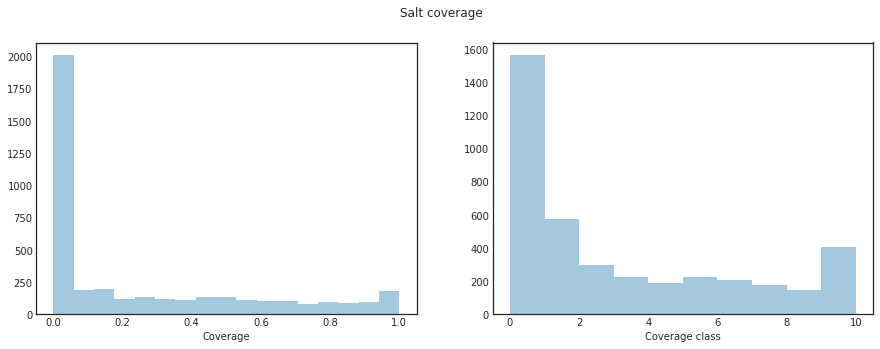

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5,1,'Depth distribution')

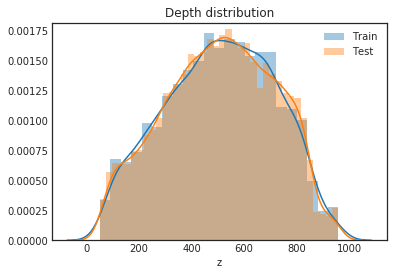

In [9]:
#Plotting the depth distributions¶

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

In [10]:
# Create train/validation split stratified by salt coverage

ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state= 520720)

In [11]:
def build_model():
    def conv(f, k=3, act='relu'):
        return Conv2D(f, (k, k), activation=act, kernel_initializer='he_normal', padding='same')
    def _res_conv(inputs, f, k=3): # very simple residual module
        channels = int(inputs.shape[-1])
        
        cs = inputs
        
        cs = BatchNormalization() (cs)
        cs = Activation('relu') (cs)
        cs = conv(f, 3, act=None) (cs)
        
        cs = BatchNormalization() (cs)
        cs = Activation('relu') (cs)
        cs = conv(f, 3, act=None) (cs)
        
        if f!=channels:
            t1 = conv(f, 1, None) (inputs) # identity mapping
        else:
            t1 = inputs
        
        out = Add()([t1, cs]) # t1 + c2
        return out
    def pool():
        return MaxPooling2D((2, 2))
    def up(x, shape):
        x = Lambda(lambda x: tf.image.resize_bilinear(x, shape, align_corners=True)) (x)
        x = Conv2D(K.int_shape(x)[-1]//2, (2, 2), activation=None, kernel_initializer='he_normal', padding='same') (x)
        return x
    
    inputs = Input(shape=(img_size_ori, img_size_ori, 1))
    depths = Input(shape=(1,))
    preprocess1 = Lambda(lambda x: x/255.0) (inputs)
    
    r = 16
    rep = 4
    mid_rep = 3
    x = preprocess1
    
    skip_connections = []
    shapes = []
    pad_mode = ['same', 'valid', 'same', 'valid']
    
    for t in range(rep):
        x = conv(r*int(2**t), 3, None) (x)
        x = _res_conv(x, r*int(2**t), 3)
        x = _res_conv(x, r*int(2**t), 3)
        x = BatchNormalization() (x)
        x = Activation('relu') (x)
        skip_connections.append(x)
        shapes.append(K.int_shape(x)[1:3])
        x = pool() (x)
        x = Dropout(0.2) (x)
    
    shape = K.int_shape(x)[1:3]
    aux = Lambda(lambda x: x/1000.0) (depths)
    aux = RepeatVector(np.prod(np.asarray(shape))) (aux)
    aux = Reshape((*shape,1)) (aux)
    x = concatenate([x, aux])
    
    x = conv(r*int(2**rep), 3, None) (x)
    for t in range(mid_rep):
        x = _res_conv(x, r*int(2**rep))
    
    for t, s, p in zip(reversed(range(rep)), reversed(skip_connections), reversed(shapes)):
        x = BatchNormalization() (x)
        x = Activation('relu') (x)
        x = up(x, p)
        x = concatenate([s, x])
        x = Dropout(0.2) (x)
        x = conv(r*int(2**t), 3, None) (x)
        x = _res_conv(x, r*int(2**t), 3)
        x = _res_conv(x, r*int(2**t), 3)
    x = BatchNormalization() (x)
    x = Activation('relu') (x)
    outputs = Conv2D(1, (1, 1), activation=None, kernel_initializer='he_normal', padding='valid') (x)
    return Model([inputs, depths], [outputs])

In [12]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def lb(label, pred):
    return tf.py_func(get_iou_vector, [label, pred > 0], tf.float64)

In [13]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

In [14]:
def bce(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_true, K.sigmoid(y_pred)))

In [15]:
#Data augmentation
def more_data(x, y, d):
    # flip lr
    x = np.append(x, x[:,:,::-1], axis=0)
    y = np.append(y, y[:,:,::-1], axis=0)
    d = np.append(d, d, axis=0)
    
    # warp
    s = x.shape[2]//2
    x = np.append(x, np.roll(x, s, axis=2), axis=0)
    y = np.append(y, np.roll(y, s, axis=2), axis=0)
    d = np.append(d, d, axis=0)
    
    nx = np.append( x[:,:,:s][:,:,::-1], x[:,:,s:], axis=2 )
    ny = np.append( y[:,:,:s][:,:,::-1], y[:,:,s:], axis=2 )
    x = np.append(x, nx, axis=0)
    y = np.append(y, ny, axis=0)
    d = np.append(d, d, axis=0)
    
    return x, y, d


In [16]:
import gc
x_train, y_train, depth_train = more_data(x_train, y_train, depth_train)
gc.collect()
print(x_train.shape)
print(depth_train.shape)
print(y_valid.shape)

(25600, 101, 101, 1)
(25600,)
(800, 101, 101, 1)


In [17]:
model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 101, 101, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [18]:
c = optimizers.adam(lr = 0.01)
model.compile(loss=bce, optimizer=c, metrics=[lb])
model_checkpoint = ModelCheckpoint(save_model_name,monitor='lb', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='lb', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 50
history = model.fit([x_train, depth_train], y_train,
                    validation_data=[[x_valid, depth_test], y_valid], 
                    epochs=epochs,
                    batch_size=32,
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=2, shuffle=True)

Train on 25600 samples, validate on 800 samples
Epoch 1/50
 - 170s - loss: 0.3111 - lb: 0.5170 - val_loss: 0.4288 - val_lb: 0.4642

Epoch 00001: lb improved from -inf to 0.51696, saving model to Unet_resnet_v5-1080.model
Epoch 2/50
 - 162s - loss: 0.2166 - lb: 0.5961 - val_loss: 0.2132 - val_lb: 0.5831

Epoch 00002: lb improved from 0.51696 to 0.59608, saving model to Unet_resnet_v5-1080.model
Epoch 3/50
 - 163s - loss: 0.1824 - lb: 0.6522 - val_loss: 0.1589 - val_lb: 0.6950

Epoch 00003: lb improved from 0.59608 to 0.65223, saving model to Unet_resnet_v5-1080.model
Epoch 4/50
 - 164s - loss: 0.1571 - lb: 0.6864 - val_loss: 0.1650 - val_lb: 0.7075

Epoch 00004: lb improved from 0.65223 to 0.68641, saving model to Unet_resnet_v5-1080.model
Epoch 5/50
 - 164s - loss: 0.1500 - lb: 0.6961 - val_loss: 0.1724 - val_lb: 0.6907

Epoch 00005: lb improved from 0.68641 to 0.69611, saving model to Unet_resnet_v5-1080.model
Epoch 6/50
 - 162s - loss: 0.1333 - lb: 0.7194 - val_loss: 0.1407 - val_lb:

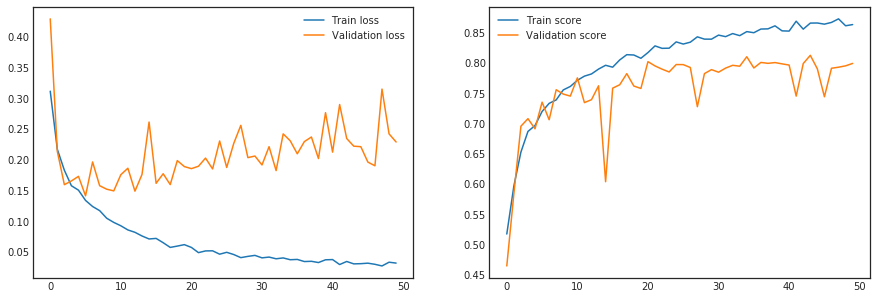

In [19]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["lb"], label="Train score")
ax_score.plot(history.epoch, history.history["val_lb"], label="Validation score")
ax_score.legend()

In [20]:
model.load_weights(save_model_name)
c = optimizers.adam(lr = 0.01)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[lb])

early_stopping = EarlyStopping(monitor='val_lb', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='val_lb', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_lb', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
epochs = 60

history = model.fit([x_train, depth_train], y_train,
                    validation_data=[[x_valid, depth_test], y_valid], 
                    epochs=epochs,
                    batch_size=32,
                    callbacks=[ model_checkpoint,reduce_lr,early_stopping], 
                    verbose=2, shuffle=True)

Train on 25600 samples, validate on 800 samples
Epoch 1/60
 - 336s - loss: 0.2322 - lb: 0.8752 - val_loss: 0.4546 - val_lb: 0.8053

Epoch 00001: val_lb improved from -inf to 0.80525, saving model to Unet_resnet_v5-1080.model
Epoch 2/60
 - 327s - loss: 0.2073 - lb: 0.8804 - val_loss: 0.4030 - val_lb: 0.7996

Epoch 00002: val_lb did not improve
Epoch 3/60
 - 328s - loss: 0.2020 - lb: 0.8814 - val_loss: 0.4524 - val_lb: 0.7850

Epoch 00003: val_lb did not improve
Epoch 4/60
 - 328s - loss: 0.2024 - lb: 0.8772 - val_loss: 0.3736 - val_lb: 0.7921

Epoch 00004: val_lb did not improve
Epoch 5/60
 - 327s - loss: 0.2098 - lb: 0.8707 - val_loss: 0.3821 - val_lb: 0.7861

Epoch 00005: val_lb did not improve
Epoch 6/60
 - 328s - loss: 0.2027 - lb: 0.8738 - val_loss: 0.3490 - val_lb: 0.8043

Epoch 00006: val_lb did not improve
Epoch 7/60
 - 328s - loss: 0.2066 - lb: 0.8714 - val_loss: 0.3866 - val_lb: 0.7756

Epoch 00007: val_lb did not improve

Epoch 00007: ReduceLROnPlateau reducing learning rate 

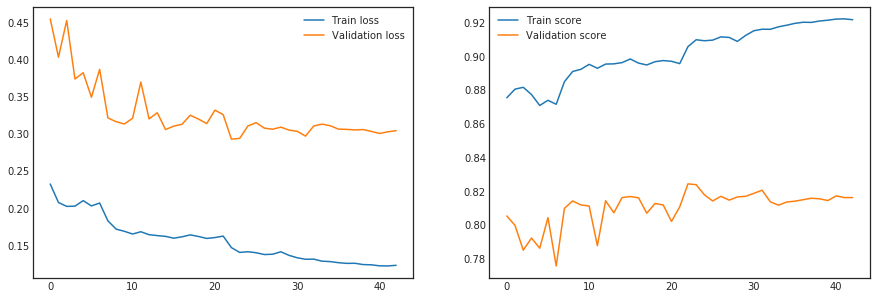

In [21]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["lb"], label="Train score")
ax_score.plot(history.epoch, history.history["val_lb"], label="Validation score")
ax_score.legend()

In [22]:
model.load_weights(save_model_name)

for l in model.layers:
    if str(l.name).startswith('batch_norm'):
        l.trainable=False
        print('Freezed layer {:s}'.format(str(l.name)))

c = optimizers.sgd(lr = 0.0001)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[lb])
epochs = 20

history = model.fit([x_train, depth_train], y_train,
                    validation_data=[[x_valid, depth_test], y_valid], 
                    epochs=epochs,
                    batch_size=16,
                    callbacks=[ model_checkpoint ], 
                    verbose=2, shuffle=True)

Freezed layer batch_normalization_1
Freezed layer batch_normalization_2
Freezed layer batch_normalization_3
Freezed layer batch_normalization_4
Freezed layer batch_normalization_5
Freezed layer batch_normalization_6
Freezed layer batch_normalization_7
Freezed layer batch_normalization_8
Freezed layer batch_normalization_9
Freezed layer batch_normalization_10
Freezed layer batch_normalization_11
Freezed layer batch_normalization_12
Freezed layer batch_normalization_13
Freezed layer batch_normalization_14
Freezed layer batch_normalization_15
Freezed layer batch_normalization_16
Freezed layer batch_normalization_17
Freezed layer batch_normalization_18
Freezed layer batch_normalization_19
Freezed layer batch_normalization_20
Freezed layer batch_normalization_21
Freezed layer batch_normalization_22
Freezed layer batch_normalization_23
Freezed layer batch_normalization_24
Freezed layer batch_normalization_25
Freezed layer batch_normalization_26
Freezed layer batch_normalization_27
Freezed la

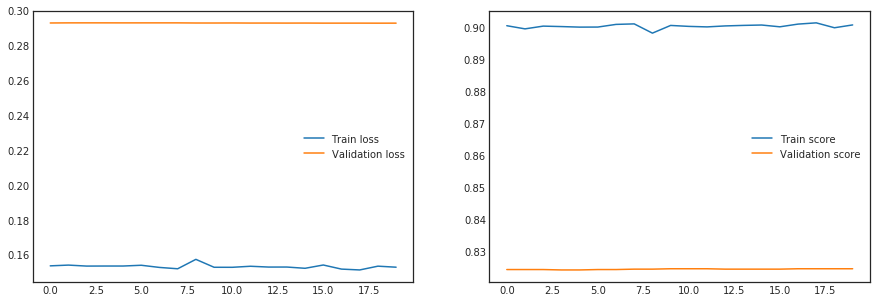

In [23]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["lb"], label="Train score")
ax_score.plot(history.epoch, history.history["val_lb"], label="Validation score")
ax_score.legend()

In [24]:
model.load_weights(save_model_name)

In [25]:
def predict_result(model,x_test,depth_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect = x_test[:,:,::-1]
    preds_test = model.predict([x_test,depth_test]).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict([x_test_reflect,depth_test]).reshape(-1, img_size_target, img_size_target)
    preds_test += preds_test2_refect[:,:,::-1]
    return preds_test/2

In [26]:
preds_valid = predict_result(model,x_valid,depth_test,img_size_target)

In [27]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)



In [28]:
## Scoring for last model, choose threshold by validation data 
thresholds = np.linspace(-0.5, 0.5, 100)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)

HBox(children=(IntProgress(value=0), HTML(value='')))


[0.8215   0.821625 0.821625 0.8215   0.821375 0.821375 0.821375 0.821375
 0.82125  0.821125 0.821375 0.821375 0.821375 0.82175  0.821875 0.822
 0.822    0.822    0.822    0.822    0.8215   0.821625 0.82175  0.821625
 0.82175  0.82175  0.821875 0.821625 0.821625 0.821625 0.821625 0.821625
 0.821375 0.82125  0.821375 0.821375 0.821625 0.82175  0.821625 0.82125
 0.821375 0.821375 0.821375 0.82125  0.8215   0.8215   0.821375 0.821125
 0.82075  0.819625 0.8215   0.821875 0.82325  0.824    0.826125 0.826375
 0.826    0.825875 0.825625 0.825625 0.825625 0.8255   0.825625 0.82525
 0.825125 0.82525  0.825    0.824875 0.82475  0.824625 0.8245   0.8245
 0.82475  0.82475  0.8245   0.82425  0.825625 0.825625 0.8255   0.8255
 0.82525  0.826375 0.826375 0.8265   0.8265   0.8265   0.826375 0.82625
 0.826375 0.825875 0.8255   0.82525  0.82525  0.825125 0.825    0.825
 0.825    0.824875 0.824625 0.82475 ]


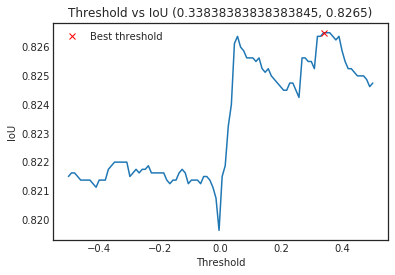

In [29]:
# instead of using default 0 as threshold, use validation data to find the best threshold.
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [30]:
"""
used for converting the decoded image to rle mask
Fast compared to previous one
"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [31]:
x_test = np.array([(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale=True))) for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)
x_depth_test = test_df.z.values


HBox(children=(IntProgress(value=0, max=18000), HTML(value='')))

In [32]:
preds_test = predict_result(model,x_test,x_depth_test,img_size_target)

In [33]:

t1 = time.time()
pred_dict = {idx: rle_encode(preds_test[i] > threshold_best) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}
t2 = time.time()

print(f"Usedtime = {t2-t1} s")

HBox(children=(IntProgress(value=0, max=18000), HTML(value='')))


Usedtime = 1.7149217128753662 s


In [34]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [35]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 8.150483827061123 hours
